In [29]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.model_selection import KFold

In [85]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

PassengerId = test["PassengerId"]
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [86]:
full_data = [train, test]

for df in full_data:
    df["Name_length"] = df["Name"].apply(len)
    df["Has_Cabin"] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["Alone"] = 0
    df.loc[df["FamilySize"] == 1, "Alone"] = 1
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Fare"] = df["Fare"].fillna(train["Fare"].median())
    age_avg = df["Age"].mean()
    age_std = df["Age"].std()
    age_null_count = df["Age"].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    df["Age"][np.isnan(df["Age"])] = age_null_random_list
    df["Age"] = df["Age"].astype(int)
train["CategoricalFare"] = pd.qcut(train["Fare"], 4)
train["CategoricalAge"] = pd.cut(train["Age"], 5)

In [87]:
def get_title(name):
    title_search = re.search("([A-Za-z]+)\.", name)
    if title_search:
        return title_search.group(1)
    return "　"

In [88]:
for df in full_data:
    df["Title"] = df["Name"].apply(get_title)
    df["Title"] = df["Title"].replace(["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace("Ms", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")
    df["Sex"] = df["Sex"].map({"female": 0, "male": 1}).astype(int)
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df["Title"] = df["Title"].map(title_mapping)
    df["Title"] = df["Title"].fillna(0)
    df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
    df.loc[df["Fare"] <= 7.91, "Fare"] = 0
    df.loc[(df["Fare"] > 7.91) & (df["Fare"] <= 14.454), "Fare"] = 1
    df.loc[(df["Fare"] > 14.454) & (df["Fare"] <= 31), "Fare"] = 2
    df.loc[df["Fare"] > 31, "Fare"] = 3
    df["Fare"] = df["Fare"].astype(int)
    df.loc[df["Age"] <= 16, "Age"] = 0
    df.loc[(df["Age"] > 16) & (df["Age"] <= 32), "Age"] = 1
    df.loc[(df["Age"] > 32) & (df["Age"] <= 48), "Age"] = 2
    df.loc[(df["Age"] > 48) & (df["Age"] <= 64), "Age"] = 3
    df.loc[df["Age"] > 64, "Age"] = 4

In [89]:
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis=1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis=1)
test = test.drop(drop_elements, axis=1)

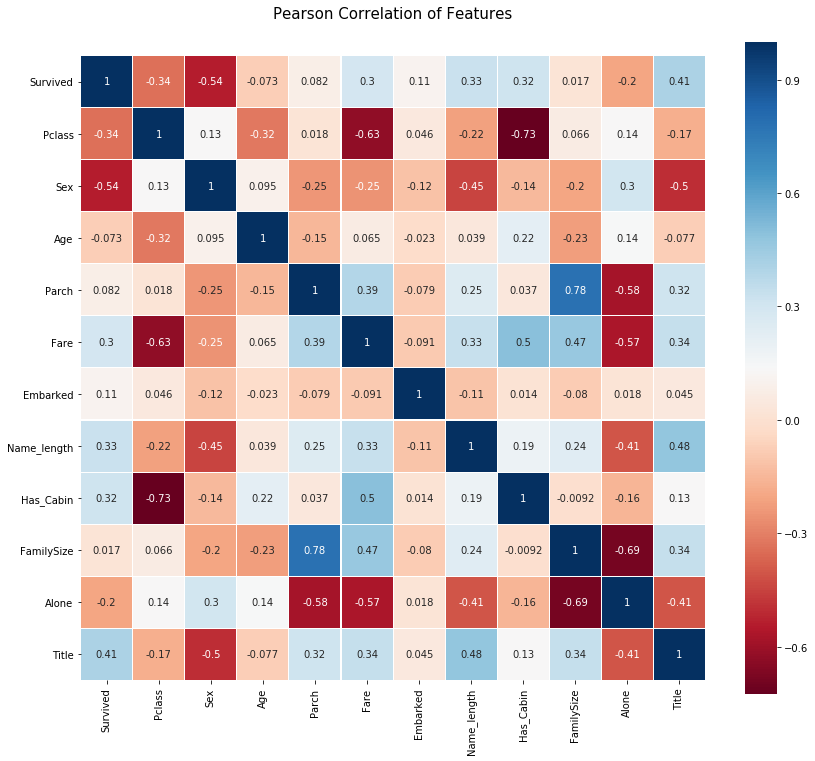

In [65]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)

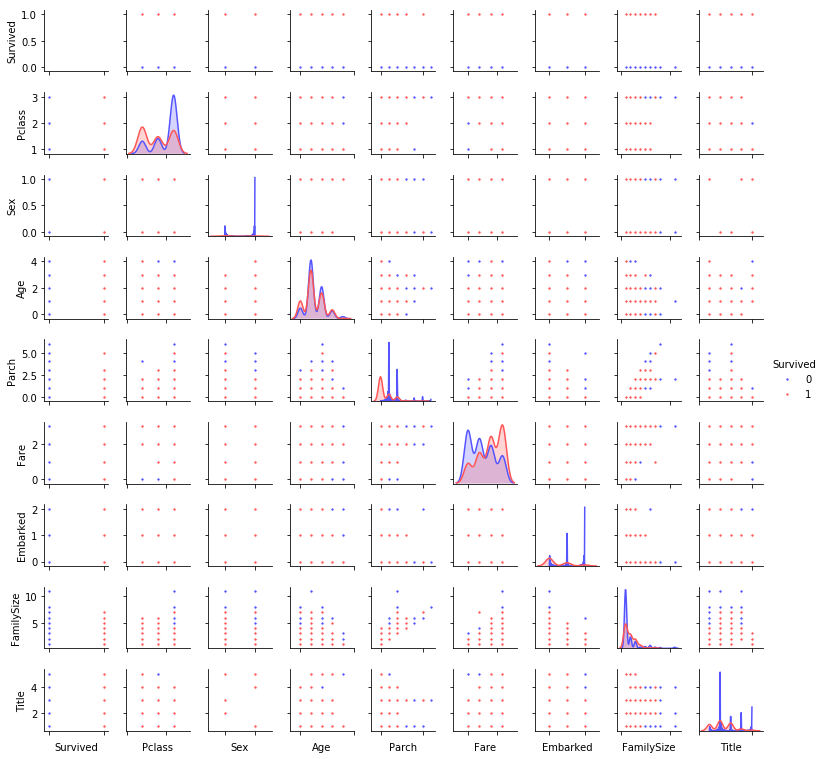

In [66]:
g = sns.pairplot(train[[u"Survived", u"Pclass", u"Sex", u"Age", u"Parch", u"Fare", u"Embarked", u"FamilySize", u"Title"]], hue="Survived", palette="seismic", size=1.2, diag_kind="kde", diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [90]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [91]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params["random_state"] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

In [92]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
        oof_test[:] = oof_test_skf.mean(axis=0)
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [93]:
rf_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    "warm_start": True,
    # "max_features": 0.2,
    "max_depth": 6,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "verbose": 0
}

et_params = {
    "n_jobs": -1,
    "n_estimators": 500,
    # "max_features": 0.5,
    "max_depth": 8,
    "min_samples_leaf": 2,
    "verbose": 0
}

ada_params = {
    "n_estimators": 500,
    "learning_rate": 0.75
}

gb_params = {
    "n_estimators": 500,
    # "max_features": 0.2,
    "max_depth": 5,
    "min_samples_leaf": 2,
    "verbose": 0
}

svc_params = {
    "kernel": "linear",
    "C": 0.025
}

In [94]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [95]:
y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis=1)
x_train = train.values
x_test = test.values

In [96]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print("Traning is complete")

Traning is complete


In [97]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

In [98]:
rf_features = list(rf_feature)
et_features = list(et_feature)
ada_features = list(ada_feature)
gb_features = list(gb_feature)

In [99]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({"features": cols,
                                 "Random Forest feature importances": rf_features,
                                "Extra Trees feature importances": et_features,
                                 "AdaBoost feature importances": ada_features,
                                 "Gradient Boost feature importances": gb_features})

In [100]:
# 
trace = go.Scatter(
y=feature_dataframe["Random Forest feature importances"].values,
x=feature_dataframe["features"].values,
mode="markers",
marker=dict(sizemode="diameter", sizeref=1, size=25, 
           color=feature_dataframe["Random Forest feature importances"]. values,
           colorscale="Portland",
           showscale=True),
text=feature_dataframe["features"].values)
data = [trace]

layout = go.Layout(
autosize=True,
title="Random Forest Feature Importance",
hovermode="closest",
yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
showlegend=False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

# 
trace = go.Scatter(
y=feature_dataframe["Extra Trees feature importances"].values,
x=feature_dataframe["features"].values,
mode="markers",
marker=dict(sizemode="diameter", sizeref=1, size=25, 
           color=feature_dataframe["Extra Trees feature importances"].values,
           colorscale="Portland",
           showscale=True),
text=feature_dataframe["features"].values
)
data = [trace]

layout = go.Layout(
autosize=True,
title="Extra Trees Feature Importance",
hovermode="closest",
yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
showlegend=False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

# 
trace = go.Scatter(
y=feature_dataframe["AdaBoost feature importances"].values,
x=feature_dataframe["features"].values,
mode="markers",
marker=dict(sizemode="diameter", sizeref=1, size=25, 
           color=feature_dataframe["AdaBoost feature importances"].values,
           colorscale="Portland",
           showscale=True),
text=feature_dataframe["features"].values
)
data = [trace]

layout = go.Layout(
autosize=True,
title="AdaBoost Feature Importance",
hovermode="closest",
yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
showlegend=False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

# 
trace = go.Scatter(
y=feature_dataframe["Gradient Boost feature importances"].values,
x=feature_dataframe["features"].values,
mode="markers",
marker=dict(sizemode="diameter", sizeref=1, size=25, 
           color=feature_dataframe["Gradient Boost feature importances"].values,
           colorscale="Portland",
           showscale=True),
text=feature_dataframe["features"].values
)
data = [trace]

layout = go.Layout(
autosize=True,
title="Gradient Boosting Feature Importance",
hovermode="closest",
yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
showlegend=False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="scatter2010")

In [101]:
feature_dataframe["mean"] = feature_dataframe.mean(axis=1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.134583,0.132466,0.038,0.098564,0.100903
1,Sex,0.217129,0.378390,0.224,0.010463,0.207496
2,Age,0.042035,0.036025,0.022,0.064806,0.041216
3,Parch,0.021990,0.016951,0.154,0.020815,0.053439
4,Fare,0.084002,0.060054,0.028,0.061376,0.058358
5,Embarked,0.026443,0.029099,0.014,0.032048,0.025397
6,Has_Cabin,0.062953,0.085163,0.022,0.054685,0.056200
7,FamilySize,0.083709,0.051573,0.092,0.138488,0.091442
8,Alone,0.013967,0.020729,0.006,0.006193,0.011722
9,Title,0.313190,0.189551,0.400,0.512561,0.353826


In [102]:
y = feature_dataframe["mean"].values
x = feature_dataframe["features"].values
data = [go.Bar(
x=x,
y=y,
width=0.5,
marker=dict(color=feature_dataframe["mean"].values,
           colorscale="Portland",
           showscale=True,
           reversescale=False),
opacity=0.6
)]

layout = go.Layout(
autosize=True,
title="Barplots of Mean Feature Importance",
hovermode="closest",
yaxis=dict(title="Feature Importance", ticklen=5, gridwidth=2),
showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="bar-direct-labels")

In [103]:
base_predictions_train = pd.DataFrame(
{"RandomForest": rf_oof_train.ravel(),
"ExtraTrees": et_oof_train.ravel(),
"AdaBoost": ada_oof_train.ravel(),
"GradientBoost": gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [104]:
data = [go.Heatmap(
z=base_predictions_train.astype(float).corr().values,
x=base_predictions_train.columns.values,
y=base_predictions_train.columns.values,
colorscale="Viridis",
showscale=True,
reversescale=True)]
py.iplot(data, filename="labelled-heatmap")

In [105]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [108]:
x_train

array([[0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 1., 0., 1.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [106]:
gbm = xgb.XGBClassifier(
# learning_rate=0.02,
max_depth=4,
min_child_weight=2,
# gamma=1,
gamma=0.9,
subsample=0.8,
colsample_bytree=0.8,
objective="binary:logistic",
nthread=-1,
scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [107]:
StackingSubmission = pd.DataFrame({"PassengerId": PassengerId,
                                  "Survived": predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

In [24]:
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

categorical_features = ["Alone", "Sex", "Pclass", "Embarked"]
train_data = lgbm.Dataset(data=X_val_train, label=y_val_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgbm.Dataset(data=X_val_test, label=y_val_test, categorical_feature=categorical_features, free_raw_data=False)

final_train_set = lgbm.Dataset(data=train_df, label=y, categorical_feature=categorical_features, free_raw_data=False)

In [114]:
feature_dataframe.shape[0]

10

In [119]:
lgbm_params = {
    "boosting_type": "gbdt",
    "application": "binary",
    "learning_rate": 0.15,
    "min_data_in_leaf": 20,
    "feature_fraction": np.sqrt(feature_dataframe.shape[0]) / feature_dataframe.shape[0],
    "num_leaves": 41,
    "metric": "binary_logloss",
    "drop_rate": 0.15
}

In [120]:
evaluation_results = {}
clf = lgbm.train(
    train_set=train_data,
    params=lgbm_params,
    valid_sets=[train_data, test_data],
    valid_names=["Train", "Test"],
    evals_result=evaluation_results,
    num_boost_round=500,
    early_stopping_rounds=100,
    verbose_eval=20)
optimum_boost_rounds = clf.best_iteration

Training until validation scores don't improve for 100 rounds.
[20]	Train's binary_logloss: 0.649304	Test's binary_logloss: 0.656146
[40]	Train's binary_logloss: 0.648945	Test's binary_logloss: 0.656309
[60]	Train's binary_logloss: 0.648586	Test's binary_logloss: 0.655986
[80]	Train's binary_logloss: 0.648353	Test's binary_logloss: 0.655909
[100]	Train's binary_logloss: 0.648034	Test's binary_logloss: 0.655608
[120]	Train's binary_logloss: 0.647783	Test's binary_logloss: 0.655661
[140]	Train's binary_logloss: 0.647595	Test's binary_logloss: 0.65577
[160]	Train's binary_logloss: 0.647425	Test's binary_logloss: 0.655629
[180]	Train's binary_logloss: 0.647303	Test's binary_logloss: 0.655514
[200]	Train's binary_logloss: 0.647212	Test's binary_logloss: 0.65543
[220]	Train's binary_logloss: 0.647062	Test's binary_logloss: 0.655489
[240]	Train's binary_logloss: 0.647012	Test's binary_logloss: 0.655508
[260]	Train's binary_logloss: 0.646914	Test's binary_logloss: 0.65559
[280]	Train's binary_

In [107]:
clf_final = lgbm.train(
    train_set=final_train_set,
    params=lgbm_params,
    num_boost_round=optimum_boost_rounds,
    verbose_eval=0)

y_pred = np.round(clf_final.predict(x_test)).astype(int)

In [108]:
StackingSubmission = pd.DataFrame(
    {"PassengerId": PassengerId,
     "Survived": y_pred})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)